In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from flareTools import id_segments

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec14/'

Idea: generate a FFD for all Kepler targets in TESS. Compare the slope to the FFD for Kepler observations. Is there a measurable difference in the slope? If so, this is probably due to the fact that the TESS filter is redder + wider than Kepler.

In [17]:
tic_gaia_table_14 = pd.read_csv('ticGAIA14.csv')
tic_gaia_table_15 = pd.read_csv('ticGAIA15.csv')
param_table_14 = pd.read_csv('14_param_out.csv')
param_table_15 = pd.read_csv('15_param_out.csv')
flare_table_14 = pd.read_csv('14_flare_out.csv')
flare_table_15 = pd.read_csv('15_flare_out.csv')
flare_gaia_table_14 = pd.merge(tic_gaia_table_14, flare_table_14, on='TIC')
flare_gaia_table_15 = pd.merge(tic_gaia_table_15, flare_table_15, on='TIC')
print(len(flare_gaia_table_14), len(flare_gaia_table_15))

df_1415 = pd.concat([flare_gaia_table_14, flare_gaia_table_15])
param_1415 = pd.concat([param_table_14, param_table_15])
print(len(df_1415))

5082 3147
8229


In [31]:
# Now figure out which of these are in the Kepler field
kic2tic = pd.read_csv('KIC2TIC.csv')
mask = np.isin(df_1415['TIC'], kic2tic['TIC'])
df = df_1415[mask]
param = param_1415[np.isin(param_1415['TIC'], kic2tic['TIC'])]
len(df)

1467

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


107 flare stars in Kepler field


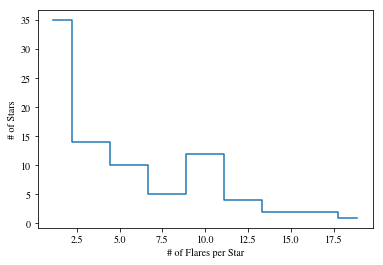

In [64]:
unique_tic = df['TIC'].drop_duplicates().as_matrix()
num_flares = np.zeros(len(unique_tic))
for idx, val in enumerate(unique_tic):
    num_flares[idx] = len(df[df['TIC'] == val])

bins = np.linspace(0, 20, num=10)
hist, bins = np.histogram(num_flares, bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xlabel('# of Flares per Star')
plt.ylabel('# of Stars')
print(str(len(unique_tic)) + ' flare stars in Kepler field')

In [41]:
ed = (df['ed'].values*u.day).to(u.s)
energy = (ed*df['lum']*u.erg/u.s).value
df['energy'] = energy
tstop = df['t1']
tstart = df['t0']

tess_time = (2*u.minute).to(u.day).value

# This is not recorded by the pipeline, should go back and add this to param tables
# Just fill in with a rough value for now (this is for GJ1243)
med_flux_err = 0.0017559020080163174

# CPA doesnt usually identify the whole flare, these duration measurements are probably
# too small
# Scaling up ALL durations makes the FFD steeper
dur = ((tstop-tstart).values*u.day).to(u.s).value
ed = (df['ed'].values*u.day).to(u.s).value

sn = ed / np.sqrt(ed + (med_flux_err * dur))

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


In [42]:
# Improved poisson error
def Perror(n):
    err_down = n * (1. - 1. / (9. * n) -1./(3. * np.sqrt(n)))**3 - n
    err_up = n + np.sqrt(n + 0.75) + 1.0 - n 
    return err_down, err_up

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
 

Text(0, 0.5, 'log Cum. Flare Freq (#/day)')

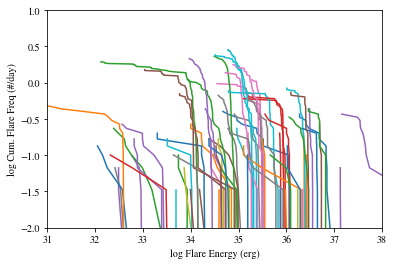

In [71]:
for TIC in np.unique(TICs):
    mask = df['TIC'] == TIC
    ed_sort = np.argsort(ed[mask])
    energy_sort = energy[mask][ed_sort]
    sn_sort = sn[mask][ed_sort]
    x_vals = energy_sort
    log_x_vals = np.log10(x_vals)
    y_vals = np.arange(0.001, len(energy[mask]))[::-1]/30
    log_y_vals = np.log10(y_vals)
    log_x_err = 1/np.log(10)/sn_sort/np.log10(ed[mask][ed_sort])
    _, perror = Perror(10**log_y_vals*tess_time)
    perror = perror/tess_time
    log_y_err = 1/np.log(10)*perror/y_vals

    plt.errorbar(log_x_vals, log_y_vals)#, xerr=log_x_err, yerr=log_y_err, alpha=0.5)
plt.xlim(31, 38)
plt.ylim(-2, 1)
plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Cum. Flare Freq (#/day)')